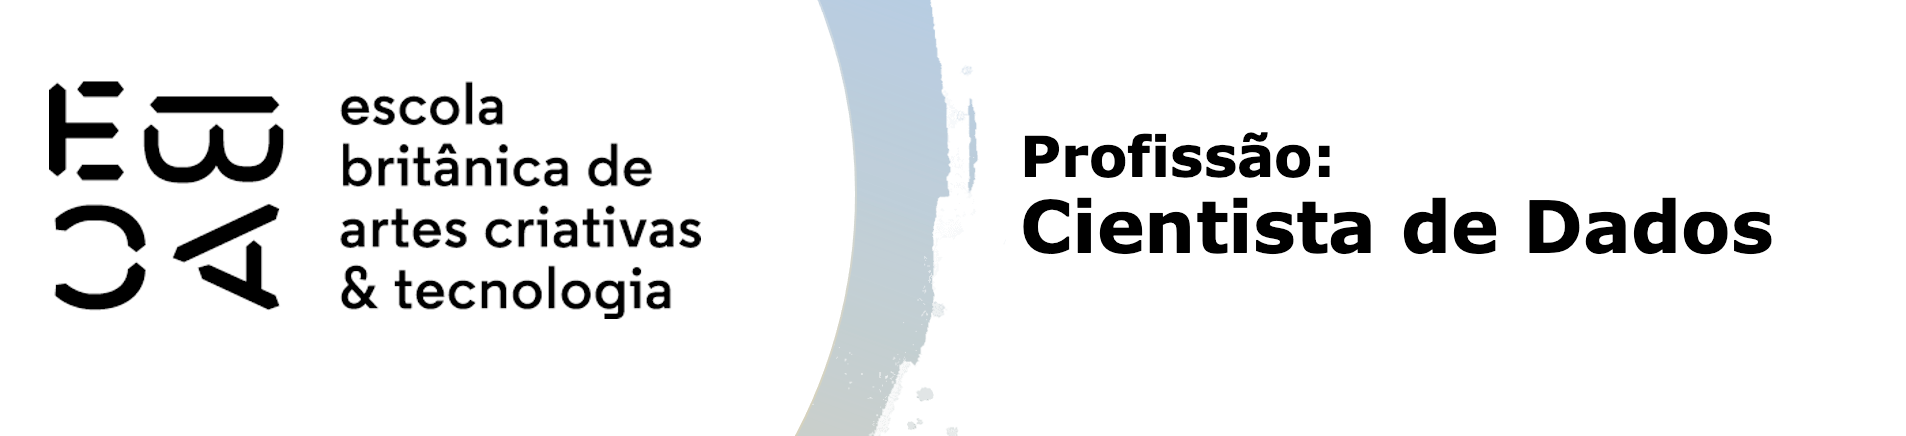

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import t
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_feather('credit_scoring.ftr')
df['data_ref'] = pd.to_datetime(df['data_ref'])
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [2]:
limite_data = df['data_ref'].max() - pd.DateOffset(months=3)
df_amostra = df[df['data_ref'] < limite_data]
df_amostra

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549995,2015-11-01,2107,F,S,S,0,Empresário,Superior completo,Casado,Casa,27,4.676712,2.0,9766.79,False
549996,2015-11-01,3100,F,S,S,0,Empresário,Superior completo,Casado,Casa,54,15.558904,2.0,55288.72,False
549997,2015-11-01,14692,F,N,N,0,Pensionista,Médio,Solteiro,Casa,63,NaN,1.0,8711.06,False
549998,2015-11-01,2990,M,S,S,0,Assalariado,Superior completo,Casado,Casa,29,1.128767,2.0,51248.02,False


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [3]:
df.groupby(df['data_ref'].dt.to_period('M')).size().reset_index(name='quantidade')


,data_ref,quantidade
0,2015-01,50000
1,2015-02,50000
2,2015-03,50000
3,2015-04,50000
4,2015-05,50000
5,2015-06,50000
6,2015-07,50000
7,2015-08,50000
8,2015-09,50000
9,2015-10,50000


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [4]:
df.select_dtypes(include=['float64', 'int64']).describe()

for col in df.select_dtypes(include=['object', 'category', 'bool']).columns:
    print(f'\n{col}')
    print(df[col].value_counts(normalize=True))
    print(df[col].value_counts())



sexo
F    0.672773
M    0.327227
Name: sexo, dtype: float64
F    504580
M    245420
Name: sexo, dtype: int64

posse_de_veiculo
N    0.610605
S    0.389395
Name: posse_de_veiculo, dtype: float64
N    457954
S    292046
Name: posse_de_veiculo, dtype: int64

posse_de_imovel
S    0.671589
N    0.328411
Name: posse_de_imovel, dtype: float64
S    503692
N    246308
Name: posse_de_imovel, dtype: int64

tipo_renda
Assalariado         0.514320
Empresário          0.230283
Pensionista         0.168353
Servidor público    0.086563
Bolsista            0.000481
Name: tipo_renda, dtype: float64
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: tipo_renda, dtype: int64

educacao
Médio                  0.675781
Superior completo      0.272408
Superior incompleto    0.039295
Fundamental            0.011433
Pós graduação          0.001083
Name: educacao, dtype: float64
Médio                  506836
Superior compl


sexo
mau       False     True 
sexo                     
F     91.947759  8.052241
M     92.660337  7.339663

posse_de_veiculo
mau                   False     True 
posse_de_veiculo                     
N                 92.121043  7.878957
S                 92.274847  7.725153

posse_de_imovel
mau                  False     True 
posse_de_imovel                     
N                91.152135  8.847865
S                92.684021  7.315979

tipo_renda
mau                   False     True 
tipo_renda                           
Assalariado       91.908280  8.091720
Bolsista          95.844875  4.155125
Empresário        92.354903  7.645097
Pensionista       91.731675  8.268325
Servidor público  94.191491  5.808509

educacao
mau                      False     True 
educacao                                
Fundamental          90.833819  9.166181
Médio                91.963870  8.036130
Pós graduação        92.733990  7.266010
Superior completo    92.843088  7.156912
Superior incompleto  

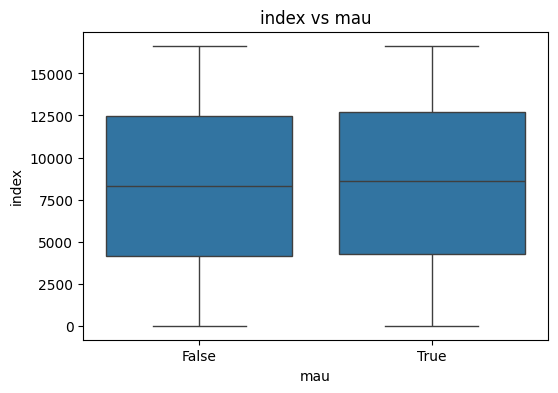

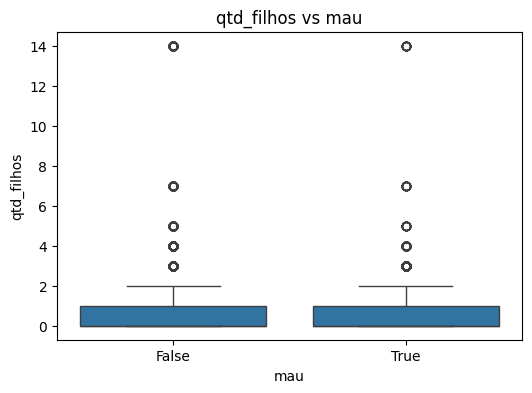

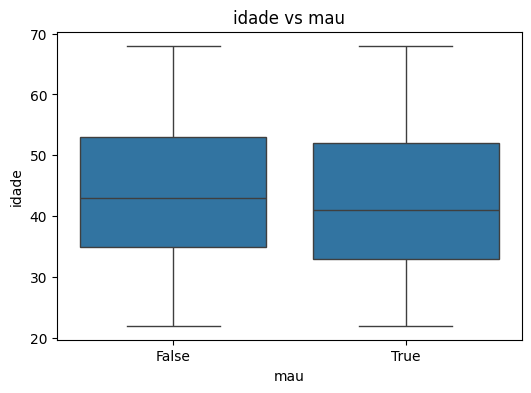

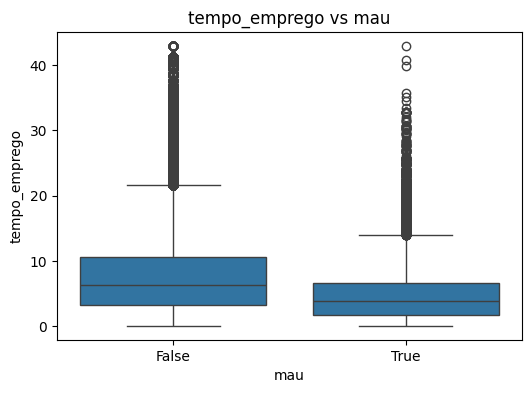

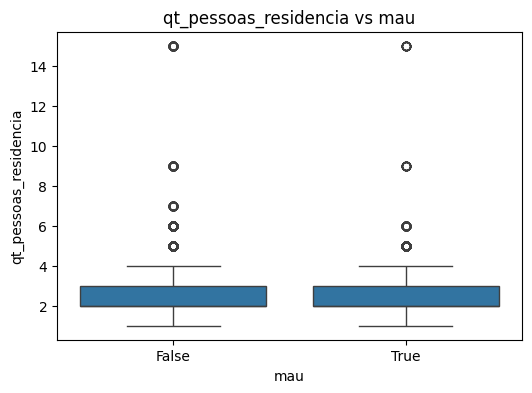

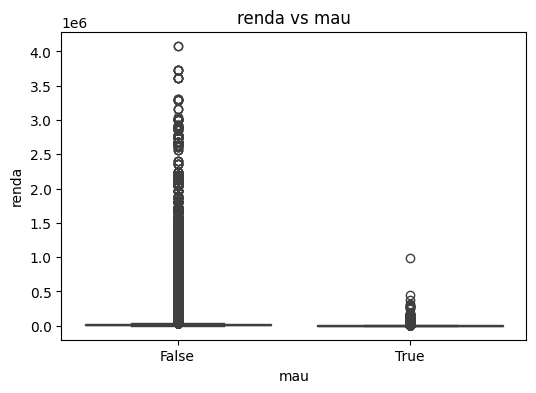

In [5]:
variavel_resposta = 'mau'

for col in df.select_dtypes(include=['object', 'category', 'bool']).columns:
    print(f'\n{col}')
    print(pd.crosstab(df[col], df[variavel_resposta], normalize='index') * 100)

for col in [c for c in df.select_dtypes(include=['float64', 'int64']).columns if c != variavel_resposta]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[variavel_resposta], y=df[col])
    plt.title(f'{col} vs {variavel_resposta}')
    plt.show()


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [6]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
if df['tempo_emprego'].isna().any():
    df['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True)
metadados

,dtype,nmissing,valores_unicos
data_ref,datetime64[ns],0,15
index,int64,0,16650
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6


In [7]:
variaveis_numericas = df.select_dtypes(include=['float64', 'int64']).columns
for col in variaveis_numericas:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]
    print(f'{col}: {len(outliers)} outliers')
for col in variaveis_numericas:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], limite_inferior, limite_superior)


index: 0 outliers
qtd_filhos: 10016 outliers
idade: 0 outliers
tempo_emprego: 57123 outliers
qt_pessoas_residencia: 9629 outliers
renda: 79072 outliers


In [8]:
df['renda_log'] = np.log1p(df['renda'])
df['tempo_emprego_log'] = np.log1p(df['tempo_emprego'])
for col in ['qtd_filhos', 'qt_pessoas_residencia']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], limite_inferior, limite_superior)

In [9]:
df['tempo_emprego'] = df['tempo_emprego'].replace(0, np.nan)
df['tempo_emprego_zero'] = (df['tempo_emprego'] == 0).astype(int)
df.replace({'tempo_emprego': {0: np.nan}}, inplace=True)

In [10]:
# Agrupamento de tipo_renda
df['tipo_renda_agrupado'] = df['tipo_renda'].replace({
    'Assalariado': 'Assalariado',
    'Servidor público': 'Estável',
    'Empresário': 'Estável',
    'Bolsista': 'Estável',
    'Pensionista': 'Outros',
    'Autônomo': 'Outros'
})

# Agrupamento de educacao
df['educacao_agrupado'] = df['educacao'].replace({
    'Fundamental': 'Baixa',
    'Médio': 'Baixa',
    'Superior': 'Alta',
    'Pós-graduação': 'Alta'
})

# Agrupamento de estado_civil
df['estado_civil_agrupado'] = df['estado_civil'].replace({
    'Casado': 'Casado',
    'Solteiro': 'Solteiro',
    'Viúvo': 'Não casado',
    'Separado': 'Não casado',
    'Divorciado': 'Não casado'
})

# Agrupamento de tipo_residencia
df['tipo_residencia_agrupado'] = df['tipo_residencia'].replace({
    'Casa': 'Propria',
    'Apartamento': 'Propria',
    'Aluguel': 'Alugada',
    'Com os pais': 'Outros',
    'Outros': 'Outros'
})

def biv_agrupada(var, df):
    df = df.copy()
    df['bom'] = 1 - df['mau']
    
    g = df.groupby(var)

    biv = pd.DataFrame({
        'qt_bom': g['bom'].sum(),
        'qt_mau': g['mau'].sum(),
        'mau': g['mau'].mean(),
        var: g['mau'].mean().index,
        'cont': g['mau'].count()
    })

    biv['ep'] = np.sqrt(biv['mau'] * (1 - biv['mau']) / biv['cont'])
    biv['mau_sup'] = biv['mau'] + t.ppf(0.975, biv['cont'] - 1) * biv['ep']
    biv['mau_inf'] = biv['mau'] + t.ppf(0.025, biv['cont'] - 1) * biv['ep']

    biv['logit'] = np.log(biv['mau'] / (1 - biv['mau']))
    biv['logit_sup'] = np.log(biv['mau_sup'] / (1 - biv['mau_sup']))
    biv['logit_inf'] = np.log(biv['mau_inf'] / (1 - biv['mau_inf']))

    woe_base = np.log(df['mau'].mean() / (1 - df['mau'].mean()))
    biv['woe'] = biv['logit'] - woe_base
    biv['woe_sup'] = biv['logit_sup'] - woe_base
    biv['woe_inf'] = biv['logit_inf'] - woe_base

    fig, ax = plt.subplots(2, 1, figsize=(9, 6))
    ax[0].plot(biv[var], biv['woe'], ':bo', label='WOE')
    ax[0].plot(biv[var], biv['woe_sup'], 'o:r', label='Limite superior')
    ax[0].plot(biv[var], biv['woe_inf'], 'o:r', label='Limite inferior')
    ax[0].set_xticks(range(len(biv)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(loc='upper right')

    biv['cont'].plot.bar(ax=ax[1])
    ax[1].set_ylabel("Quantidade")
    ax[1].set_title(f"Distribuição por categoria - {var}")

    plt.tight_layout()
    plt.show()

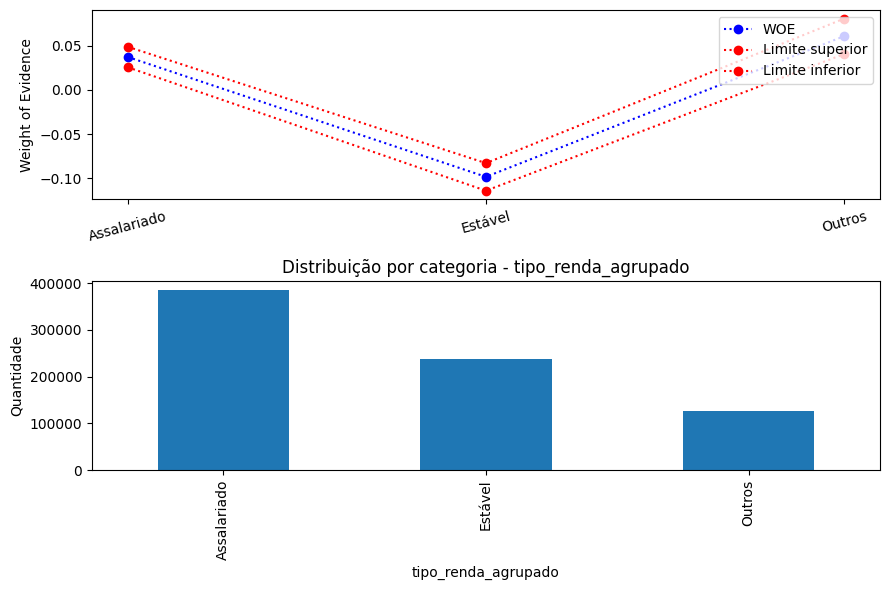

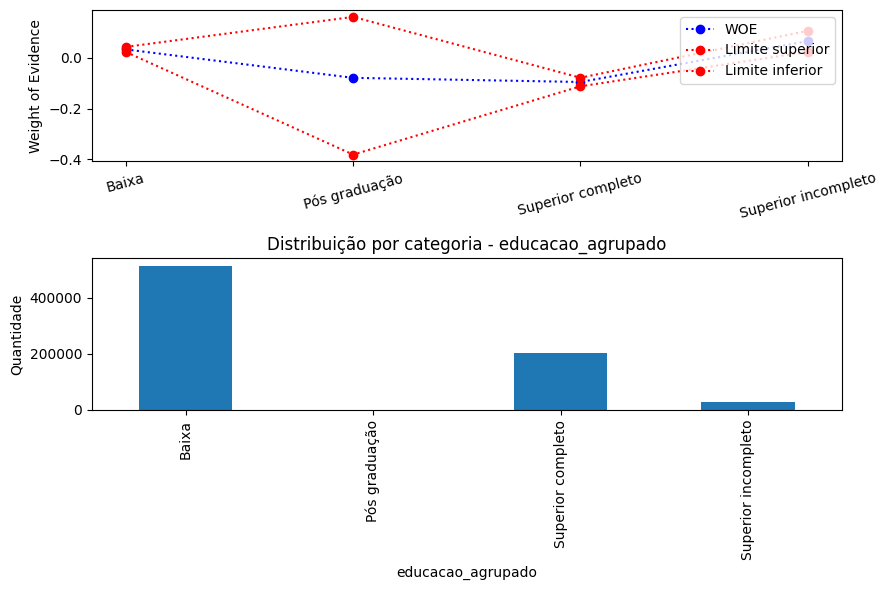

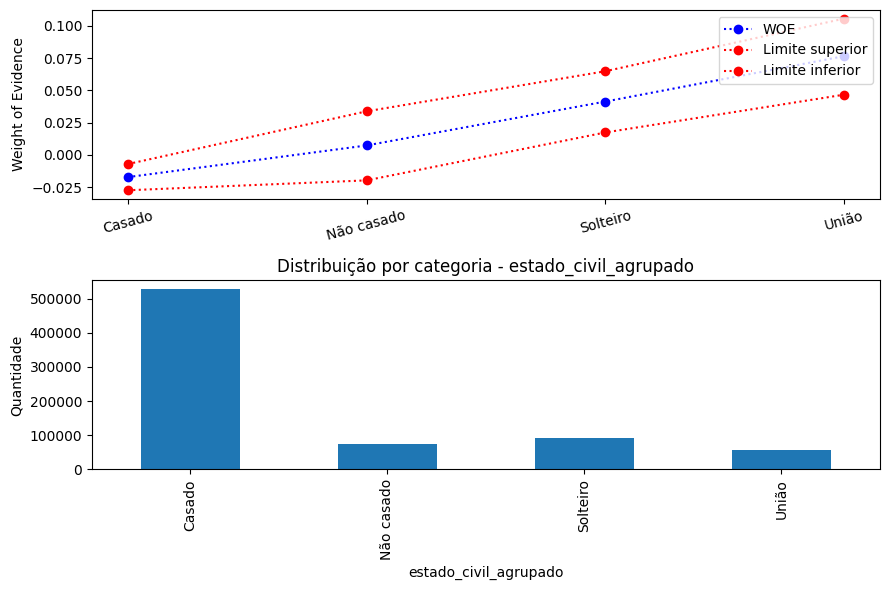

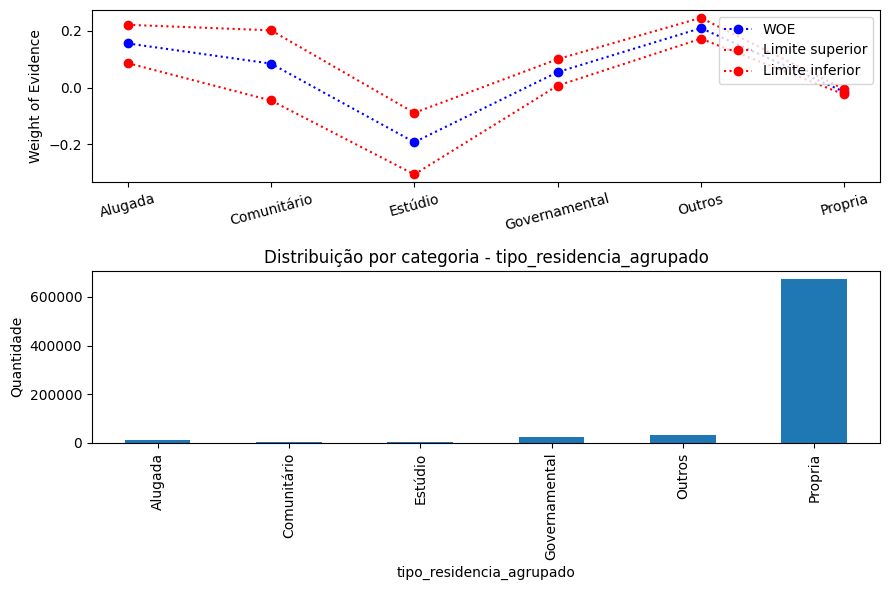

In [11]:
biv_agrupada('tipo_renda_agrupado', df)
biv_agrupada('educacao_agrupado', df)
biv_agrupada('estado_civil_agrupado', df)
biv_agrupada('tipo_residencia_agrupado', df)

In [12]:
df['mau'] = df['mau'].astype(int)

variaveis = ['idade', 'renda_log', 'tempo_emprego_log', 'sexo', 
             'tipo_renda_agrupado', 'educacao_agrupado', 
             'estado_civil_agrupado', 'tipo_residencia_agrupado']

formula = 'mau ~ ' + ' + '.join(variaveis)

modelo = smf.logit(formula, data=df).fit()

Optimization terminated successfully.
         Current function value: 0.234319
         Iterations 8


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [13]:
df_desenvolvimento = df[df['data_ref'] < limite_data].copy()
df_oot = df[df['data_ref'] >= limite_data].copy()

X_dev = df_desenvolvimento[variaveis]
X_oot = df_oot[variaveis]

y_dev = df_desenvolvimento['mau']
y_oot = df_oot['mau']

y_dev_pred_prob = modelo.predict(df_desenvolvimento)
y_oot_pred_prob = modelo.predict(df_oot)

y_dev_pred_class = (y_dev_pred_prob >= 0.5).astype(int)
y_oot_pred_class = (y_oot_pred_prob >= 0.5).astype(int)

acc_dev = accuracy_score(y_dev, y_dev_pred_class)
acc_oot = accuracy_score(y_oot, y_oot_pred_class)

def ks_score(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    return max(tpr - fpr)

ks_dev = ks_score(y_dev, y_dev_pred_prob)
ks_oot = ks_score(y_oot, y_oot_pred_prob)

gini_dev = 2 * roc_auc_score(y_dev, y_dev_pred_prob) - 1
gini_oot = 2 * roc_auc_score(y_oot, y_oot_pred_prob) - 1

print(f"Acurácia: {acc_dev:.4f}")
print(f"KS:       {ks_dev:.4f}")
print(f"Gini:     {gini_dev:.4f}")

print(f"Acurácia: {acc_oot:.4f}")
print(f"KS:       {ks_oot:.4f}")
print(f"Gini:     {gini_oot:.4f}")


Acurácia: 0.9423
KS:       0.3970
Gini:     0.5390
Acurácia: 0.8670
KS:       0.3556
Gini:     0.4893


## Criar um pipeline utilizando o sklearn pipeline 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [14]:
df.isnull().sum()
df[df.columns[df.isnull().any()]].dtypes
df['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True)
df['educacao'].fillna(df['educacao'].mode()[0], inplace=True)
df['tempo_emprego_nan'] = df['tempo_emprego'].isna().astype(int)

In [15]:
df.isnull().sum()

data_ref                    0
index                       0
sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego               0
qt_pessoas_residencia       0
renda                       0
mau                         0
renda_log                   0
tempo_emprego_log           0
tempo_emprego_zero          0
tipo_renda_agrupado         0
educacao_agrupado           0
estado_civil_agrupado       0
tipo_residencia_agrupado    0
tempo_emprego_nan           0
dtype: int64

In [16]:
df[df.columns[df.isnull().any()]].dtypes


Series([], dtype: object)

In [17]:
df['tempo_emprego'].describe()


count    750000.000000
mean          7.247569
std           4.663740
min           0.117808
25%           3.635616
50%           7.473973
75%           9.090411
max          17.272603
Name: tempo_emprego, dtype: float64

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [18]:
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    df = df[(df[col] >= limite_inferior) & (df[col] <= limite_superior)]


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [19]:
variaveis = ['idade', 'renda_log', 'tempo_emprego_log', 'sexo', 
             'tipo_renda_agrupado', 'educacao_agrupado', 
             'estado_civil_agrupado', 'tipo_residencia_agrupado']

X = pd.get_dummies(df[variaveis], drop_first=True)
y = df['mau']

modelo_lr = LogisticRegression(max_iter=1000)
selector = RFE(modelo_lr, n_features_to_select=5)
selector.fit(X, y)

variaveis_selecionadas = X.columns[selector.support_]
print("Variáveis selecionadas:", list(variaveis_selecionadas))

KeyboardInterrupt: 

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [20]:
X = pd.get_dummies(df[variaveis], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

print("Variância explicada por componente:", pca.explained_variance_ratio_)
print("Variância total explicada:", pca.explained_variance_ratio_.sum())

Variância explicada por componente: [0.13619795 0.10124905 0.08619021 0.06815228 0.06533505]
Variância total explicada: 0.45712455437194466


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [21]:
colunas_categoricas = [
    'sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia'
]

df_dummies = pd.get_dummies(df, columns=colunas_categoricas, drop_first=True)


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def preprocessamento(df):
    df = df.copy()
    
    if df['tempo_emprego'].isna().any():
        df['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True)
    if df['educacao'].isna().any():
        df['educacao'].fillna(df['educacao'].mode()[0], inplace=True)
    
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lim_inf = Q1 - 1.5 * IQR
        lim_sup = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lim_inf, lim_sup)  # substituição conservadora
    
    df = pd.get_dummies(df, columns=['posse_de_veiculo'], drop_first=True)
    
    X = df.select_dtypes(include=['float64', 'int64'])
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(X_scaled)
    
    return X_pca

In [23]:
X_transformado = preprocessamento(df)
print(X_transformado.shape)

(735204, 5)


In [24]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [25]:
from pycaret.classification import *

setup(
    data=df,
    target='mau',
    categorical_features=[
        'sexo', 'posse_de_veiculo', 'posse_de_imovel',
        'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'
    ],
    ignore_features=['data_ref', 'index'],
    session_id=123,
    normalize=True,
    remove_outliers=False,
    transformation=False,
    fix_imbalance=False,
    verbose=True
)

# Criar o modelo LightGBM
modelo_lgbm = create_model('lightgbm')

# Avaliação visual do modelo
evaluate_model(modelo_lgbm)

# Otimização dos hiperparâmetros
modelo_tunado = tune_model(modelo_lgbm)

# Plots
plot_model(modelo_lgbm, plot='feature')
plot_model(modelo_lgbm, plot='confusion_matrix')
plot_model(modelo_lgbm, plot='auc')
plot_model(modelo_lgbm, plot='ks')

# Finalização e exportação
final_model = finalize_model(modelo_lgbm)
save_model(final_model, 'modelo_credito_lgbm')


,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(750000, 30)"
5,Transformed train set shape,"(525000, 30)"
6,Transformed test set shape,"(225000, 30)"
7,Ignore features,2
8,Numeric features,5
9,Categorical features,7


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:36:21
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


KeyboardInterrupt: 

### Treinar um modelo de regressão logistica com o resultado

In [27]:
# Recompor variáveis transformadas
df['renda_log'] = np.log1p(df['renda'])

df['tempo_emprego'] = df['tempo_emprego'].replace(0, np.nan)
df['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True)
df['tempo_emprego_log'] = np.log1p(df['tempo_emprego'])

# Agrupamentos
df['tipo_renda_agrupado'] = df['tipo_renda'].replace({
    'Assalariado': 'Assalariado',
    'Servidor público': 'Estável',
    'Empresário': 'Estável',
    'Bolsista': 'Estável',
    'Pensionista': 'Outros',
    'Autônomo': 'Outros'
})

df['educacao_agrupado'] = df['educacao'].replace({
    'Fundamental': 'Baixa',
    'Médio': 'Baixa',
    'Superior': 'Alta',
    'Pós-graduação': 'Alta'
})

df['estado_civil_agrupado'] = df['estado_civil'].replace({
    'Casado': 'Casado',
    'Solteiro': 'Solteiro',
    'Viúvo': 'Não casado',
    'Separado': 'Não casado',
    'Divorciado': 'Não casado'
})

df['tipo_residencia_agrupado'] = df['tipo_residencia'].replace({
    'Casa': 'Propria',
    'Apartamento': 'Propria',
    'Aluguel': 'Alugada',
    'Com os pais': 'Outros',
    'Outros': 'Outros'
})


In [29]:
variaveis = ['idade', 'renda_log', 'tempo_emprego_log', 'sexo', 
             'tipo_renda_agrupado', 'educacao_agrupado', 
             'estado_civil_agrupado', 'tipo_residencia_agrupado']
df['mau'] = df['mau'].astype(int)

formula = 'mau ~ ' + ' + '.join(variaveis)

modelo = smf.logit(formula, data=df).fit()


Optimization terminated successfully.
         Current function value: 0.234115
         Iterations 8


### Salvar o pickle file do modelo treinado

In [30]:
import pickle

nome_arquivo = 'modelo_logit_final.pkl'

with open(nome_arquivo, 'wb') as arquivo:
    pickle.dump(modelo, arquivo)


In [31]:
with open('modelo_logit_final.pkl', 'rb') as arquivo:
    modelo_carregado = pickle.load(arquivo)


# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [34]:
import pandas as pd
from pycaret.classification import *

df = pd.read_feather('credit_scoring.ftr')
df['mau'] = df['mau'].astype(int)

In [35]:
clf_setup = setup(
    data=df,
    target='mau',
    categorical_features=[
        'sexo', 'posse_de_veiculo', 'posse_de_imovel',
        'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'
    ],
    ignore_features=['data_ref', 'index'],
    session_id=42,
    normalize=True,
    remove_outliers=True,
    transformation=True,
    fix_imbalance=True,
    verbose=True
)


,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(1144220, 30)"
5,Transformed train set shape,"(919220, 30)"
6,Transformed test set shape,"(225000, 30)"
7,Ignore features,2
8,Numeric features,5
9,Categorical features,7


In [36]:
modelo_lgbm = create_model('lightgbm')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9058,0.7784,0.2112,0.3371,0.2597,0.2122,0.2189
1,0.9063,0.7800,0.2146,0.3420,0.2637,0.2165,0.2232
2,0.9059,0.7817,0.2095,0.3363,0.2582,0.2108,0.2176
3,0.9065,0.7872,0.2202,0.3462,0.2692,0.2219,0.2284
4,0.9062,0.7781,0.2080,0.3378,0.2575,0.2104,0.2175
5,0.9052,0.7805,0.2110,0.3323,0.2581,0.2101,0.2163
6,0.9056,0.7760,0.2110,0.3351,0.2589,0.2113,0.2178
7,0.9064,0.7777,0.2093,0.3397,0.2590,0.2120,0.2191
8,0.9072,0.7790,0.2200,0.3508,0.2704,0.2236,0.2306


In [37]:
evaluate_model(modelo_lgbm)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [38]:
evaluate_model(modelo_lgbm)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [39]:
modelo_tunado = tune_model(modelo_lgbm)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9082,0.7677,0.1664,0.3284,0.2209,0.1776,0.1893
1,0.9088,0.7684,0.1720,0.3367,0.2277,0.1846,0.1964
2,0.9079,0.7708,0.1691,0.3280,0.2231,0.1795,0.1907
3,0.9087,0.7770,0.1866,0.3450,0.2422,0.1982,0.2089
4,0.9066,0.7680,0.1708,0.3183,0.2223,0.1774,0.1872
5,0.9078,0.7690,0.1722,0.3287,0.2260,0.1820,0.1929
6,0.9088,0.7669,0.1695,0.3354,0.2252,0.1823,0.1944
7,0.9089,0.7693,0.1737,0.3389,0.2297,0.1866,0.1984
8,0.9091,0.7686,0.1795,0.3444,0.2360,0.1928,0.2044


Fitting 10 folds for each of 10 candidates, totalling 100 fits


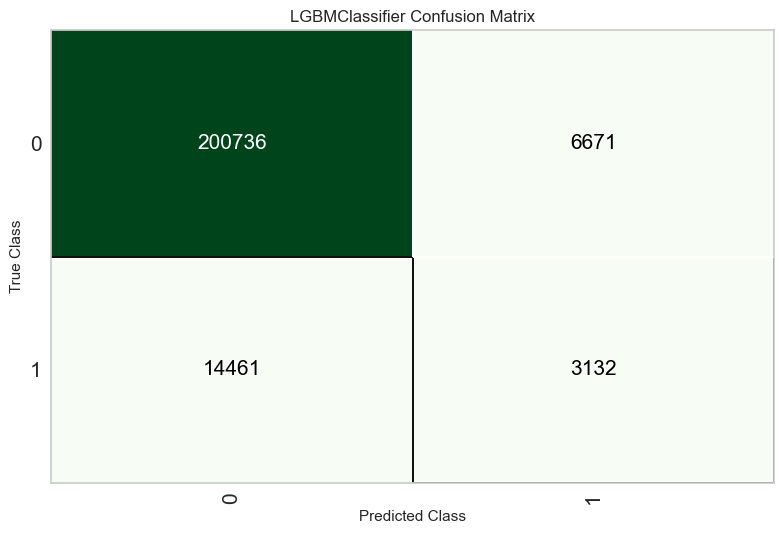

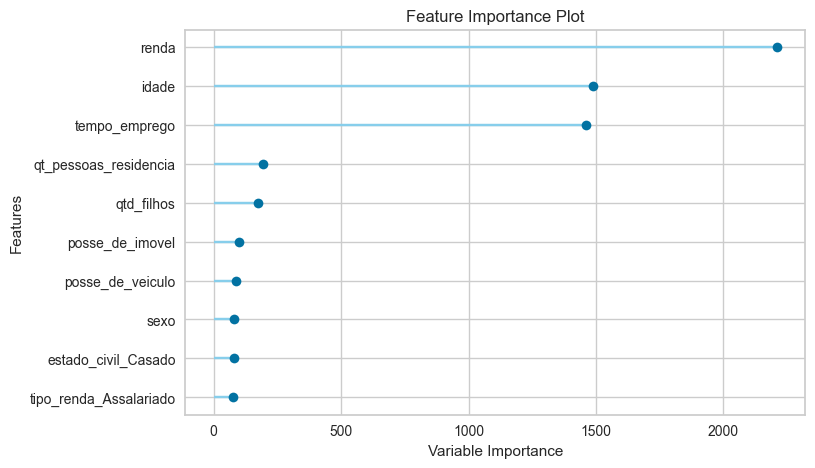

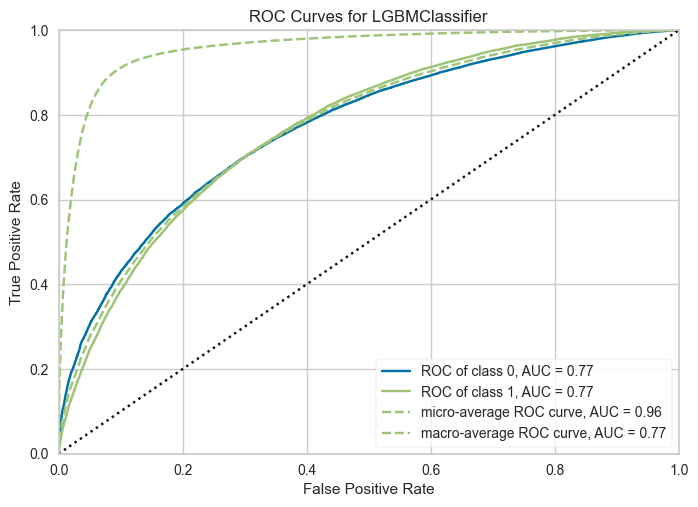

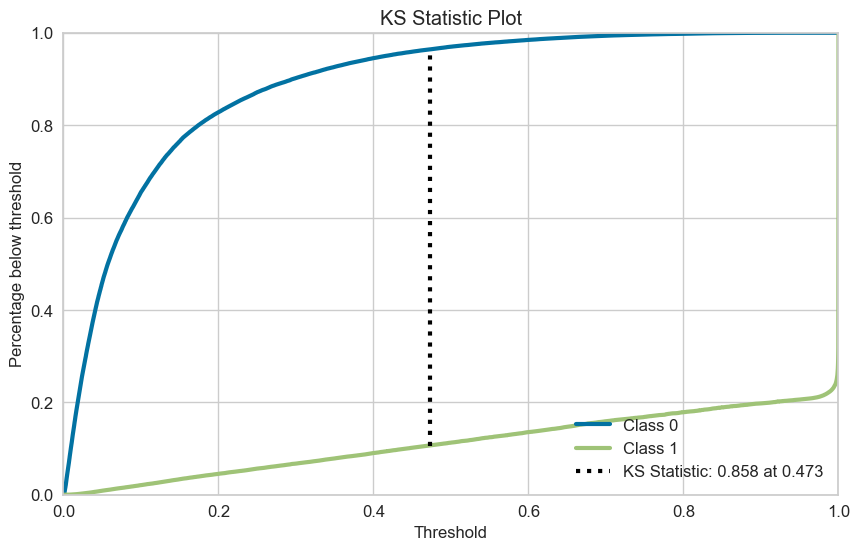

In [40]:
plot_model(modelo_tunado, plot='confusion_matrix')
plot_model(modelo_tunado, plot='feature')
plot_model(modelo_tunado, plot='auc')
plot_model(modelo_tunado, plot='ks')


In [41]:
modelo_final = finalize_model(modelo_tunado)
save_model(modelo_final, 'modelo_lgbm_pycaret')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            

In [42]:
modelo_carregado = load_model('modelo_lgbm_pycaret')


Transformation Pipeline and Model Successfully Loaded


### Salvar o arquivo do modelo treinado

In [43]:
from pycaret.classification import save_model

save_model(modelo_final, 'modelo_lgbm_pycaret')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.